<a href="https://colab.research.google.com/github/jonbaer/googlecolab/blob/master/Planning_feature_exploration_add_phrase_search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Search Planning - does your proposed new feature add information to the ranking function?

Planning relevance experiments usually means conversations about "adding an item to the index to match on" or "parsing out a new attribute of the query" or "new way of query-document similarity". What we'll call a new **feature** in the ranking function.

Note even a complicated API, with lots of conditional branches, etc is still a "ranking function".

This notebook helps us answer two questions

1. Does the new feature **add information** that existing features do not have? (If not, it may not be worth pursuing)
2. Does the new feature **improve pairwise accuracy** between relevant / irrelevant docs? Does it improve relevance and make it easier for a classifier to tell the difference between relevant / irrelevant documents?

We don't need to be deploying machine learning for ranking just to use ML to help answer these questions and help us better plan.

## Setup

### Download the WANDS e-commerce search dataset

[WANDS is a dataset from Wayfair](https://github.com/wayfair/WANDS) for search experimentation

In [ ]:
!git clone https://github.com/wayfair/WANDS.git
!ls WANDS/dataset

Cloning into 'WANDS'...
remote: Enumerating objects: 40, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 40 (delta 7), reused 23 (delta 3), pack-reused 0
Receiving objects: 100% (40/40), 33.32 MiB | 6.79 MiB/s, done.
Resolving deltas: 100% (7/7), done.
Updating files: 100% (19/19), done.
label.csv  product.csv	query.csv


### Install dependencies

* SearchArray - a BM25 index
* Pystemmer - for simple stemming
* openai - for openai API access

In [ ]:
!pip install SearchArray==0.0.57 pystemmer openai shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 8.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 303.0/303.0 kB 16.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.5/325.5 kB 29.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 35.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.1 MB/s eta 0:00:00
  Created wheel for SearchArray: filename=searcharray-0.0.57-cp310-cp310-linux_x86_64.whl size=2789919 sha256=2e1aeee9755d22e4fb9f70f09ecd325e938357c87ce18e8f34a3fdff460e99cf
  Stored in directory: /root/.cache/pip/wheels/04/58/ac/4391a14b427a50300cfbd0ca20

In [ ]:
import pandas as pd
import numpy as np
import Stemmer
import string
from searcharray import SearchArray

### Load WANDS dataset

In [ ]:
products = pd.read_csv("WANDS/dataset/product.csv",
                       delimiter="\t")
queries = pd.read_csv("WANDS/dataset/query.csv",
                       delimiter="\t")
labels = pd.read_csv("WANDS/dataset/label.csv",
                      delimiter="\t")

In [ ]:
products

,product_id,product_name,product_class,category hierarchy,product_description,product_features,rating_count,average_rating,review_count
0,0,solid wood platform bed,Beds,Furniture / Bedroom Furniture / Beds & Headboa...,"good , deep sleep can be quite difficult to ha...",overallwidth-sidetoside:64.7|dsprimaryproducts...,15.0,4.5,15.0
1,1,all-clad 7 qt . slow cooker,Slow Cookers,Kitchen & Tabletop / Small Kitchen Appliances ...,"create delicious slow-cooked meals , from tend...",capacityquarts:7|producttype : slow cooker|pro...,100.0,2.0,98.0
2,2,all-clad electrics 6.5 qt . slow cooker,Slow Cookers,Kitchen & Tabletop / Small Kitchen Appliances ...,prepare home-cooked meals on any schedule with...,features : keep warm setting|capacityquarts:6....,208.0,3.0,181.0
3,3,all-clad all professional tools pizza cutter,"Slicers, Peelers And Graters",Browse By Brand / All-Clad,this original stainless tool was designed to c...,overallwidth-sidetoside:3.5|warrantylength : l...,69.0,4.5,42.0
4,4,baldwin prestige alcott passage knob with roun...,Door Knobs,Home Improvement / Doors & Door Hardware / Doo...,the hardware has a rich heritage of delivering...,compatibledoorthickness:1.375 '' |countryofori...,70.0,5.0,42.0
...,...,...,...,...,...,...,...,...,...
42989,42989,malibu pressure balanced diverter fixed shower...,Shower Panels,Home Improvement / Bathroom Remodel & Bathroom...,the malibu pressure balanced diverter fixed sh...,producttype : shower panel|spraypattern : rain...,3.0,4.5,2.0
42990,42990,emmeline 5 piece breakfast dining set,Dining Table Sets,Furniture / Kitchen & Dining Furniture / Dinin...,NaN,basematerialdetails : steel| : gray wood|ofhar...,1314.0,4.5,864.0
42991,42991,maloney 3 piece pub table set,Dining Table Sets,Furniture / Kitchen & Dining Furniture / Dinin...,this pub table set includes 1 counter height t...,additionaltoolsrequirednotincluded : power dri...,49.0,4.0,41.0
42992,42992,fletcher 27.5 '' wide polyester armchair,Teen Lounge Furniture|Accent Chairs,Furniture / Living Room Furniture / Chairs & S...,"bring iconic , modern style to your space in a...",legmaterialdetails : rubberwood|backheight-sea...,1746.0,4.5,1226.0


In [ ]:
queries

,query_id,query,query_class
0,0,salon chair,Massage Chairs
1,1,smart coffee table,Coffee & Cocktail Tables
2,2,dinosaur,Kids Wall Décor
3,3,turquoise pillows,Accent Pillows
4,4,chair and a half recliner,Recliners
...,...,...,...
475,483,rustic twig,Faux Plants and Trees
476,484,nespresso vertuo next premium by breville with...,Espresso Machines
477,485,pedistole sink,Kitchen Sinks
478,486,54 in bench cushion,Furniture Cushions


In [ ]:
labels
labels.loc[labels['label'] == 'Exact', 'grade'] = 2
labels.loc[labels['label'] == 'Partial', 'grade'] = 1
labels.loc[labels['label'] == 'Irrelevant', 'grade'] = 0
labels

,id,query_id,product_id,label,grade
0,0,0,25434,Exact,2.0
1,1,0,12088,Irrelevant,0.0
2,2,0,42931,Exact,2.0
3,3,0,2636,Exact,2.0
4,4,0,42923,Exact,2.0
...,...,...,...,...,...
233443,234010,478,15439,Partial,1.0
233444,234011,478,451,Partial,1.0
233445,234012,478,30764,Irrelevant,0.0
233446,234013,478,16796,Partial,1.0


In [ ]:
judgments = labels.merge(queries, on='query_id', how='left')
judgments

,id,query_id,product_id,label,grade,query,query_class
0,0,0,25434,Exact,2.0,salon chair,Massage Chairs
1,1,0,12088,Irrelevant,0.0,salon chair,Massage Chairs
2,2,0,42931,Exact,2.0,salon chair,Massage Chairs
3,3,0,2636,Exact,2.0,salon chair,Massage Chairs
4,4,0,42923,Exact,2.0,salon chair,Massage Chairs
...,...,...,...,...,...,...,...
233443,234010,478,15439,Partial,1.0,worn leather office chair,Office Chairs
233444,234011,478,451,Partial,1.0,worn leather office chair,Office Chairs
233445,234012,478,30764,Irrelevant,0.0,worn leather office chair,Office Chairs
233446,234013,478,16796,Partial,1.0,worn leather office chair,Office Chairs


### Generate downsample

We're just hunting for promising ideas worth investing, not going deep into any one investigation.

In [ ]:
merged = labels.merge(products, on="product_id", how="inner")
downsample = merged.groupby('product_id').first().reset_index()
downsample

,product_id,id,query_id,label,grade,product_name,product_class,category hierarchy,product_description,product_features,rating_count,average_rating,review_count
0,0,17882,125,Partial,1.0,solid wood platform bed,Beds,Furniture / Bedroom Furniture / Beds & Headboa...,"good , deep sleep can be quite difficult to ha...",overallwidth-sidetoside:64.7|dsprimaryproducts...,15.0,4.5,15.0
1,1,8012,62,Exact,2.0,all-clad 7 qt . slow cooker,Slow Cookers,Kitchen & Tabletop / Small Kitchen Appliances ...,"create delicious slow-cooked meals , from tend...",capacityquarts:7|producttype : slow cooker|pro...,100.0,2.0,98.0
2,2,8013,62,Partial,1.0,all-clad electrics 6.5 qt . slow cooker,Slow Cookers,Kitchen & Tabletop / Small Kitchen Appliances ...,prepare home-cooked meals on any schedule with...,features : keep warm setting|capacityquarts:6....,208.0,3.0,181.0
3,3,39248,368,Exact,2.0,all-clad all professional tools pizza cutter,"Slicers, Peelers And Graters",Browse By Brand / All-Clad,this original stainless tool was designed to c...,overallwidth-sidetoside:3.5|warrantylength : l...,69.0,4.5,42.0
4,4,9635,76,Irrelevant,0.0,baldwin prestige alcott passage knob with roun...,Door Knobs,Home Improvement / Doors & Door Hardware / Doo...,the hardware has a rich heritage of delivering...,compatibledoorthickness:1.375 '' |countryofori...,70.0,5.0,42.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
42981,42989,34762,294,Partial,1.0,malibu pressure balanced diverter fixed shower...,Shower Panels,Home Improvement / Bathroom Remodel & Bathroom...,the malibu pressure balanced diverter fixed sh...,producttype : shower panel|spraypattern : rain...,3.0,4.5,2.0
42982,42990,44055,421,Exact,2.0,emmeline 5 piece breakfast dining set,Dining Table Sets,Furniture / Kitchen & Dining Furniture / Dinin...,None,basematerialdetails : steel| : gray wood|ofhar...,1314.0,4.5,864.0
42983,42991,32248,258,Exact,2.0,maloney 3 piece pub table set,Dining Table Sets,Furniture / Kitchen & Dining Furniture / Dinin...,this pub table set includes 1 counter height t...,additionaltoolsrequirednotincluded : power dri...,49.0,4.0,41.0
42984,42992,5808,45,Exact,2.0,fletcher 27.5 '' wide polyester armchair,Teen Lounge Furniture|Accent Chairs,Furniture / Living Room Furniture / Chairs & S...,"bring iconic , modern style to your space in a...",legmaterialdetails : rubberwood|backheight-sea...,1746.0,4.5,1226.0


### Index downsample

The sort of lexical indexing we would do in a search engine like Solr or Elasticsearch

In [ ]:
stemmer = Stemmer.Stemmer('english', maxCacheSize=0)

fold_to_ascii = dict([(ord(x), ord(y)) for x, y in zip(u"‘’´“”–-", u"'''\"\"--")])
punct_trans = str.maketrans({key: ' ' for key in string.punctuation})
all_trans = {**fold_to_ascii, **punct_trans}


def stem_word(word):
    return stemmer.stemWord(word)


def snowball_tokenizer(text):
    if type(text) == float:
        return ''
    if text is None:
        return ''
    text = text.translate(all_trans).replace("'", " ")
    split = text.lower().split()
    return [stem_word(token)
            for token in split]


def ws_tokenizer(text):
    if text is None:
        return ''
    text = text.translate(all_trans)
    split = text.lower().split()
    return split

In [ ]:
downsample['product_name_snowball'] = SearchArray.index(downsample['product_name'],
                                                        tokenizer=snowball_tokenizer)
downsample['product_description_snowball'] = SearchArray.index(downsample['product_description'],
                                                               tokenizer=snowball_tokenizer)
downsample['product_class_snowball'] = SearchArray.index(downsample['product_class'],
                                                         tokenizer=snowball_tokenizer)

downsample['product_name_ws'] = SearchArray.index(downsample['product_name'],
                                                  tokenizer=ws_tokenizer)
downsample['product_description_ws'] = SearchArray.index(downsample['product_description'],
                                                         tokenizer=ws_tokenizer)
downsample['product_class_ws'] = SearchArray.index(downsample['product_class'],
                                                   tokenizer=ws_tokenizer)

2024-06-13 09:58:25,778 - searcharray.indexing - INFO - Indexing begins


INFO:searcharray.indexing:Indexing begins


2024-06-13 09:58:25,797 - searcharray.indexing - INFO - 0 Batch Start tokenization


INFO:searcharray.indexing:0 Batch Start tokenization


2024-06-13 09:58:25,805 - searcharray.indexing - INFO - Tokenizing 42986 documents


INFO:searcharray.indexing:Tokenizing 42986 documents


2024-06-13 09:58:26,971 - searcharray.indexing - INFO - Tokenized 10000 (23.26338807983995%)


INFO:searcharray.indexing:Tokenized 10000 (23.26338807983995%)


2024-06-13 09:58:28,021 - searcharray.indexing - INFO - Tokenized 20000 (46.5267761596799%)


INFO:searcharray.indexing:Tokenized 20000 (46.5267761596799%)


2024-06-13 09:58:28,709 - searcharray.indexing - INFO - Tokenized 30000 (69.79016423951985%)


INFO:searcharray.indexing:Tokenized 30000 (69.79016423951985%)


2024-06-13 09:58:29,554 - searcharray.indexing - INFO - Tokenized 40000 (93.0535523193598%)


INFO:searcharray.indexing:Tokenized 40000 (93.0535523193598%)


2024-06-13 09:58:30,510 - searcharray.indexing - INFO - Tokenization -- vstacking


INFO:searcharray.indexing:Tokenization -- vstacking


2024-06-13 09:58:30,855 - searcharray.indexing - INFO - Tokenization -- DONE


INFO:searcharray.indexing:Tokenization -- DONE


2024-06-13 09:58:30,868 - searcharray.indexing - INFO - Inverting docs->terms


INFO:searcharray.indexing:Inverting docs->terms


2024-06-13 09:58:31,004 - searcharray.indexing - INFO - Encoding positions to bit array


INFO:searcharray.indexing:Encoding positions to bit array


2024-06-13 09:58:31,127 - searcharray.indexing - INFO - Indexing from tokenization complete


INFO:searcharray.indexing:Indexing from tokenization complete


2024-06-13 09:58:31,185 - searcharray.indexing - INFO - Indexing begins


INFO:searcharray.indexing:Indexing begins


2024-06-13 09:58:31,218 - searcharray.indexing - INFO - 0 Batch Start tokenization


INFO:searcharray.indexing:0 Batch Start tokenization


2024-06-13 09:58:31,234 - searcharray.indexing - INFO - Tokenizing 42986 documents


INFO:searcharray.indexing:Tokenizing 42986 documents


2024-06-13 09:58:34,592 - searcharray.indexing - INFO - Tokenized 10000 (23.26338807983995%)


INFO:searcharray.indexing:Tokenized 10000 (23.26338807983995%)


2024-06-13 09:58:39,885 - searcharray.indexing - INFO - Tokenized 20000 (46.5267761596799%)


INFO:searcharray.indexing:Tokenized 20000 (46.5267761596799%)


2024-06-13 09:58:41,405 - searcharray.indexing - INFO - Tokenized 30000 (69.79016423951985%)


INFO:searcharray.indexing:Tokenized 30000 (69.79016423951985%)


2024-06-13 09:58:42,786 - searcharray.indexing - INFO - Tokenized 40000 (93.0535523193598%)


INFO:searcharray.indexing:Tokenized 40000 (93.0535523193598%)


2024-06-13 09:58:43,508 - searcharray.indexing - INFO - Tokenization -- vstacking


INFO:searcharray.indexing:Tokenization -- vstacking


2024-06-13 09:58:43,715 - searcharray.indexing - INFO - Tokenization -- DONE


INFO:searcharray.indexing:Tokenization -- DONE


2024-06-13 09:58:43,765 - searcharray.indexing - INFO - Inverting docs->terms


INFO:searcharray.indexing:Inverting docs->terms


2024-06-13 09:58:44,552 - searcharray.indexing - INFO - Encoding positions to bit array


INFO:searcharray.indexing:Encoding positions to bit array


2024-06-13 09:58:44,909 - searcharray.indexing - INFO - Indexing from tokenization complete


INFO:searcharray.indexing:Indexing from tokenization complete


2024-06-13 09:58:45,049 - searcharray.indexing - INFO - Indexing begins


INFO:searcharray.indexing:Indexing begins


2024-06-13 09:58:45,062 - searcharray.indexing - INFO - 0 Batch Start tokenization


INFO:searcharray.indexing:0 Batch Start tokenization


2024-06-13 09:58:45,066 - searcharray.indexing - INFO - Tokenizing 42986 documents


INFO:searcharray.indexing:Tokenizing 42986 documents


2024-06-13 09:58:45,320 - searcharray.indexing - INFO - Tokenized 10000 (23.26338807983995%)


INFO:searcharray.indexing:Tokenized 10000 (23.26338807983995%)


2024-06-13 09:58:45,602 - searcharray.indexing - INFO - Tokenized 20000 (46.5267761596799%)


INFO:searcharray.indexing:Tokenized 20000 (46.5267761596799%)


2024-06-13 09:58:45,848 - searcharray.indexing - INFO - Tokenized 30000 (69.79016423951985%)


INFO:searcharray.indexing:Tokenized 30000 (69.79016423951985%)


2024-06-13 09:58:46,098 - searcharray.indexing - INFO - Tokenized 40000 (93.0535523193598%)


INFO:searcharray.indexing:Tokenized 40000 (93.0535523193598%)


2024-06-13 09:58:46,351 - searcharray.indexing - INFO - Tokenization -- vstacking


INFO:searcharray.indexing:Tokenization -- vstacking


2024-06-13 09:58:46,485 - searcharray.indexing - INFO - Tokenization -- DONE


INFO:searcharray.indexing:Tokenization -- DONE


2024-06-13 09:58:46,493 - searcharray.indexing - INFO - Inverting docs->terms


INFO:searcharray.indexing:Inverting docs->terms


2024-06-13 09:58:46,515 - searcharray.indexing - INFO - Encoding positions to bit array


INFO:searcharray.indexing:Encoding positions to bit array


2024-06-13 09:58:46,552 - searcharray.indexing - INFO - Indexing from tokenization complete


INFO:searcharray.indexing:Indexing from tokenization complete


2024-06-13 09:58:46,574 - searcharray.indexing - INFO - Indexing begins


INFO:searcharray.indexing:Indexing begins


2024-06-13 09:58:46,596 - searcharray.indexing - INFO - 0 Batch Start tokenization


INFO:searcharray.indexing:0 Batch Start tokenization


2024-06-13 09:58:46,602 - searcharray.indexing - INFO - Tokenizing 42986 documents


INFO:searcharray.indexing:Tokenizing 42986 documents


2024-06-13 09:58:46,882 - searcharray.indexing - INFO - Tokenized 10000 (23.26338807983995%)


INFO:searcharray.indexing:Tokenized 10000 (23.26338807983995%)


2024-06-13 09:58:47,150 - searcharray.indexing - INFO - Tokenized 20000 (46.5267761596799%)


INFO:searcharray.indexing:Tokenized 20000 (46.5267761596799%)


2024-06-13 09:58:47,405 - searcharray.indexing - INFO - Tokenized 30000 (69.79016423951985%)


INFO:searcharray.indexing:Tokenized 30000 (69.79016423951985%)


2024-06-13 09:58:47,682 - searcharray.indexing - INFO - Tokenized 40000 (93.0535523193598%)


INFO:searcharray.indexing:Tokenized 40000 (93.0535523193598%)


2024-06-13 09:58:47,983 - searcharray.indexing - INFO - Tokenization -- vstacking


INFO:searcharray.indexing:Tokenization -- vstacking


2024-06-13 09:58:48,115 - searcharray.indexing - INFO - Tokenization -- DONE


INFO:searcharray.indexing:Tokenization -- DONE


2024-06-13 09:58:48,129 - searcharray.indexing - INFO - Inverting docs->terms


INFO:searcharray.indexing:Inverting docs->terms


2024-06-13 09:58:48,196 - searcharray.indexing - INFO - Encoding positions to bit array


INFO:searcharray.indexing:Encoding positions to bit array


2024-06-13 09:58:48,283 - searcharray.indexing - INFO - Indexing from tokenization complete


INFO:searcharray.indexing:Indexing from tokenization complete


2024-06-13 09:58:48,316 - searcharray.indexing - INFO - Indexing begins


INFO:searcharray.indexing:Indexing begins


2024-06-13 09:58:48,333 - searcharray.indexing - INFO - 0 Batch Start tokenization


INFO:searcharray.indexing:0 Batch Start tokenization


2024-06-13 09:58:48,339 - searcharray.indexing - INFO - Tokenizing 42986 documents


INFO:searcharray.indexing:Tokenizing 42986 documents


2024-06-13 09:58:49,339 - searcharray.indexing - INFO - Tokenized 10000 (23.26338807983995%)


INFO:searcharray.indexing:Tokenized 10000 (23.26338807983995%)


2024-06-13 09:58:50,549 - searcharray.indexing - INFO - Tokenized 20000 (46.5267761596799%)


INFO:searcharray.indexing:Tokenized 20000 (46.5267761596799%)


2024-06-13 09:58:51,913 - searcharray.indexing - INFO - Tokenized 30000 (69.79016423951985%)


INFO:searcharray.indexing:Tokenized 30000 (69.79016423951985%)


2024-06-13 09:58:52,805 - searcharray.indexing - INFO - Tokenized 40000 (93.0535523193598%)


INFO:searcharray.indexing:Tokenized 40000 (93.0535523193598%)


2024-06-13 09:58:53,355 - searcharray.indexing - INFO - Tokenization -- vstacking


INFO:searcharray.indexing:Tokenization -- vstacking


2024-06-13 09:58:53,566 - searcharray.indexing - INFO - Tokenization -- DONE


INFO:searcharray.indexing:Tokenization -- DONE


2024-06-13 09:58:53,607 - searcharray.indexing - INFO - Inverting docs->terms


INFO:searcharray.indexing:Inverting docs->terms


2024-06-13 09:58:54,390 - searcharray.indexing - INFO - Encoding positions to bit array


INFO:searcharray.indexing:Encoding positions to bit array


2024-06-13 09:58:54,761 - searcharray.indexing - INFO - Indexing from tokenization complete


INFO:searcharray.indexing:Indexing from tokenization complete


2024-06-13 09:58:54,901 - searcharray.indexing - INFO - Indexing begins


INFO:searcharray.indexing:Indexing begins


2024-06-13 09:58:54,914 - searcharray.indexing - INFO - 0 Batch Start tokenization


INFO:searcharray.indexing:0 Batch Start tokenization


2024-06-13 09:58:54,920 - searcharray.indexing - INFO - Tokenizing 42986 documents


INFO:searcharray.indexing:Tokenizing 42986 documents


2024-06-13 09:58:55,120 - searcharray.indexing - INFO - Tokenized 10000 (23.26338807983995%)


INFO:searcharray.indexing:Tokenized 10000 (23.26338807983995%)


2024-06-13 09:58:55,332 - searcharray.indexing - INFO - Tokenized 20000 (46.5267761596799%)


INFO:searcharray.indexing:Tokenized 20000 (46.5267761596799%)


2024-06-13 09:58:55,532 - searcharray.indexing - INFO - Tokenized 30000 (69.79016423951985%)


INFO:searcharray.indexing:Tokenized 30000 (69.79016423951985%)


2024-06-13 09:58:55,753 - searcharray.indexing - INFO - Tokenized 40000 (93.0535523193598%)


INFO:searcharray.indexing:Tokenized 40000 (93.0535523193598%)


2024-06-13 09:58:56,011 - searcharray.indexing - INFO - Tokenization -- vstacking


INFO:searcharray.indexing:Tokenization -- vstacking


2024-06-13 09:58:56,127 - searcharray.indexing - INFO - Tokenization -- DONE


INFO:searcharray.indexing:Tokenization -- DONE


2024-06-13 09:58:56,139 - searcharray.indexing - INFO - Inverting docs->terms


INFO:searcharray.indexing:Inverting docs->terms


2024-06-13 09:58:56,157 - searcharray.indexing - INFO - Encoding positions to bit array


INFO:searcharray.indexing:Encoding positions to bit array


2024-06-13 09:58:56,196 - searcharray.indexing - INFO - Indexing from tokenization complete


INFO:searcharray.indexing:Indexing from tokenization complete


## Gather + normalize feature values

Gather values of our ranking function from BM25 style matches, or vector search cosine similarity, or a numerical attribute

Every query-product has a numerical score for a feature, whether it's the strength of a query match, or something about the document.

In [ ]:
def or_query(ds, field, search_query):
  tokenizer = ds[field].array.tokenizer
  return np.sum([ds[field].array.score(term)
                 for term in tokenizer(search_query)], axis=0)

# ADDED
def phrase_query(ds, field, search_query):
    tokenizer = ds[field].array.tokenizer
    terms = [term for term in tokenizer(search_query)]
    return ds[field].array.score(terms)

def and_query(ds, field, search_query):
  tokenizer = ds[field].array.tokenizer
  terms = [term for term in tokenizer(search_query)]
  all_term_matches = np.asarray([ds[field].array.score(term)
                                 for term in terms])
  term_matches = all_term_matches > 0
  and_match = np.sum(term_matches, axis=0) == len(terms)
  and_score = np.sum(all_term_matches, axis=0)
  and_score[~and_match] = 0
  return and_score

def phrase_query(ds, field, search_query):
  tokenizer = ds[field].array.tokenizer
  phrase = [term for term in tokenizer(search_query)]
  phrase_score = ds[field].array.score(phrase)
  return phrase_score

def match_all_terms(ds, field, search_query):
  and_score = and_query(ds, field, search_query)
  return and_score > 0

def match_any_terms(ds, field, search_query):
  or_score = or_query(ds, field, search_query)
  return or_score > 0

def log_features(ds, ids, query: str):

  features = {}

  # Imagine query is salon chair...
  features['name_ws_bm25'] = or_query(ds, 'product_name_ws', query)   #  <-- product_name_ws:("salon OR chair")
  features['name_snowball_bm25'] = or_query(ds, 'product_name_snowball', query)
  features['description_ws_bm25'] = or_query(ds, 'product_description_ws', query)
  features['description_snowball_bm25'] = or_query(ds, 'product_description_snowball', query)

  # ADDED!
  features['name_snowball_phrase_bm25'] = phrase_query(ds, 'product_name_snowball', query)
  features['description_snowball_phrase_bm25'] = phrase_query(ds, 'product_description_snowball', query)


  features['name_ws_matches_any_terms'] = match_any_terms(ds, 'product_name_ws', query)
  features['name_ws_matches_all_terms'] = match_all_terms(ds, 'product_name_ws', query)
  # features['average_rating'] = ds['average_rating']

  features = pd.DataFrame(features).add_prefix('feature.')
  features['query'] = query
  features['product_id'] = ds['product_id']
  return features[features['product_id'].isin(ids)]

In [ ]:
def gather_training_data(judgments, ds):
  features_dfs = []
  for idx, query in enumerate(judgments['query'].unique()):
    ids = judgments[judgments['query'] == query]['product_id'].tolist()
    features = log_features(ds=ds, ids=ids, query=query)
    features_dfs.append(features)
  features = pd.concat(features_dfs)
  return features.merge(judgments, how='left', on=['query', 'product_id'])

training_data = gather_training_data(judgments, ds=downsample,)
training_data[['feature.name_ws_matches_any_terms', 'query', 'product_id', 'label', 'grade']].merge(products[['product_id', 'product_name']], on='product_id', how='left')

,feature.name_ws_matches_any_terms,query,product_id,label,grade,product_name
0,True,salon chair,17,Irrelevant,0.0,6 '' h x 94 '' w x 1/4 '' d chair rail
1,True,salon chair,63,Partial,1.0,33 '' wide genuine leather wingback chair
2,True,salon chair,65,Partial,1.0,majorica upholstered dining chair
3,True,salon chair,95,Partial,1.0,vasta tdrafting chair
4,True,salon chair,130,Partial,1.0,kanisha 32.28 '' wide papasan chair
...,...,...,...,...,...,...
233443,True,rack glass,42872,Irrelevant,0.0,rigsby 18 oz glass water bottle
233444,True,rack glass,42930,Partial,1.0,freestanding sports rack
233445,True,pictures to hang over fireplace,7116,Partial,1.0,ebern designs paris canvas decor eiffel tower ...
233446,False,pictures to hang over fireplace,40171,Partial,1.0,giddings family theme wall hanging 8 opening p...


### Standard normalization

We normalize raw values to how many std devs plus/minus the mean they are.

In [ ]:
ftr_cols = training_data.filter(like='feature.').columns.to_list()
means = training_data[ftr_cols].mean(axis=0)
stds = training_data[ftr_cols].std(axis=0)

normed = training_data.copy()
for column in ftr_cols:
  normed[column] = ((training_data.loc[:, column] - means[column]) / stds[column])

normed

,feature.name_ws_bm25,feature.name_snowball_bm25,feature.description_ws_bm25,feature.description_snowball_bm25,feature.name_snowball_phrase_bm25,feature.description_snowball_phrase_bm25,feature.name_ws_matches_any_terms,feature.name_ws_matches_all_terms,query,product_id,id,query_id,label,grade,query_class
0,-0.831409,-1.048495,-0.568178,-0.700689,-0.119485,-0.098515,0.376460,-0.171777,salon chair,17,203605,0,Irrelevant,0.0,Massage Chairs
1,-0.641958,-0.846589,-0.955842,-1.061874,-0.119485,-0.098515,0.376460,-0.171777,salon chair,63,202601,0,Partial,1.0,Massage Chairs
2,-0.526705,-0.723758,-0.955842,-1.061874,-0.119485,-0.098515,0.376460,-0.171777,salon chair,65,58496,0,Partial,1.0,Massage Chairs
3,-0.455181,-0.647531,-0.187221,-0.345272,-0.119485,-0.098515,0.376460,-0.171777,salon chair,95,204040,0,Partial,1.0,Massage Chairs
4,-0.641958,-0.846589,-0.371725,-0.514543,-0.119485,-0.098515,0.376460,-0.171777,salon chair,130,203236,0,Partial,1.0,Massage Chairs
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233443,-0.096346,-0.258473,-0.063643,0.105087,-0.119485,-0.098515,0.376460,-0.171777,rack glass,42872,201900,487,Irrelevant,0.0,Candle Holders
233444,0.198796,0.057630,-0.955842,-1.061874,-0.119485,-0.098515,0.376460,-0.171777,rack glass,42930,202065,487,Partial,1.0,Candle Holders
233445,1.280629,0.205331,-0.955842,-1.061874,-0.119485,-0.098515,0.376460,-0.171777,pictures to hang over fireplace,7116,201064,480,Partial,1.0,Wall Art
233446,-1.416399,1.030004,1.240385,0.307824,-0.119485,-0.098515,-2.656316,-0.171777,pictures to hang over fireplace,40171,201065,480,Partial,1.0,Wall Art


### Compute pairwise differences

In [ ]:
NUM_TO_SAMPLE = 1000

pairwise = normed.sample(NUM_TO_SAMPLE).merge(normed,
                                              on='query',
                                              how='left')
pairwise = pairwise[(pairwise.product_id_x != pairwise.product_id_y)]
pairwise['grade_diff'] = pairwise['grade_x'] - pairwise['grade_y']

for column in ftr_cols:
    pairwise.loc[:, f"{column}_diff"] = (pairwise[f"{column}_x"] - pairwise[f"{column}_y"])

pairwise

<ipython-input-15-ffb789a134ce>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pairwise['grade_diff'] = pairwise['grade_x'] - pairwise['grade_y']
<ipython-input-15-ffb789a134ce>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pairwise.loc[:, f"{column}_diff"] = (pairwise[f"{column}_x"] - pairwise[f"{column}_y"])
<ipython-input-15-ffb789a134ce>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

,feature.name_ws_bm25_x,feature.name_snowball_bm25_x,feature.description_ws_bm25_x,feature.description_snowball_bm25_x,feature.name_snowball_phrase_bm25_x,feature.description_snowball_phrase_bm25_x,feature.name_ws_matches_any_terms_x,feature.name_ws_matches_all_terms_x,query,product_id_x,...,query_class_y,grade_diff,feature.name_ws_bm25_diff,feature.name_snowball_bm25_diff,feature.description_ws_bm25_diff,feature.description_snowball_bm25_diff,feature.name_snowball_phrase_bm25_diff,feature.description_snowball_phrase_bm25_diff,feature.name_ws_matches_any_terms_diff,feature.name_ws_matches_all_terms_diff
0,2.972453,3.028764,0.972366,0.686763,-0.119485,-0.098515,0.37646,5.821487,hillsby oriental rug,26128,...,Area Rugs,1.0,2.102818,2.253386,1.928208,0.594858,0.0,0.0,0.000000,5.993263
1,2.972453,3.028764,0.972366,0.686763,-0.119485,-0.098515,0.37646,5.821487,hillsby oriental rug,26128,...,Area Rugs,1.0,2.102818,2.253386,1.928208,0.557420,0.0,0.0,0.000000,5.993263
2,2.972453,3.028764,0.972366,0.686763,-0.119485,-0.098515,0.37646,5.821487,hillsby oriental rug,26128,...,Area Rugs,1.0,2.226795,2.386112,1.928208,1.748637,0.0,0.0,0.000000,5.993263
3,2.972453,3.028764,0.972366,0.686763,-0.119485,-0.098515,0.37646,5.821487,hillsby oriental rug,26128,...,Area Rugs,1.0,2.226795,2.386112,1.928208,1.748637,0.0,0.0,0.000000,5.993263
4,2.972453,3.028764,0.972366,0.686763,-0.119485,-0.098515,0.37646,5.821487,hillsby oriental rug,26128,...,Area Rugs,1.0,2.226795,2.386112,1.928208,1.748637,0.0,0.0,0.000000,5.993263
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1483866,0.752443,0.652057,-0.345473,0.723647,-0.119485,-0.098515,0.37646,-0.171777,tall storage cabinet,18096,...,Office Storage Cabinets,-1.0,2.168842,2.323987,-1.354147,-0.148253,0.0,0.0,3.032775,0.000000
1483867,0.752443,0.652057,-0.345473,0.723647,-0.119485,-0.098515,0.37646,-0.171777,tall storage cabinet,18096,...,Office Storage Cabinets,0.0,0.373102,0.399798,-1.074508,0.134537,0.0,0.0,0.000000,0.000000
1483868,0.752443,0.652057,-0.345473,0.723647,-0.119485,-0.098515,0.37646,-0.171777,tall storage cabinet,18096,...,Office Storage Cabinets,0.0,0.263865,0.282745,-0.607363,0.620610,0.0,0.0,0.000000,0.000000
1483869,0.752443,0.652057,-0.345473,0.723647,-0.119485,-0.098515,0.37646,-0.171777,tall storage cabinet,18096,...,Office Storage Cabinets,0.0,0.263865,0.282745,0.610368,1.785520,0.0,0.0,0.000000,0.000000


## What features correlate?

In [ ]:
corr_matrix = pairwise.filter(like='feature').filter(like='_diff').fillna(0).corr()
corr_matrix

,feature.name_ws_bm25_diff,feature.name_snowball_bm25_diff,feature.description_ws_bm25_diff,feature.description_snowball_bm25_diff,feature.name_snowball_phrase_bm25_diff,feature.description_snowball_phrase_bm25_diff,feature.name_ws_matches_any_terms_diff,feature.name_ws_matches_all_terms_diff
feature.name_ws_bm25_diff,1.000000,0.894341,0.196172,0.169710,0.200881,0.079588,0.537004,0.445286
feature.name_snowball_bm25_diff,0.894341,1.000000,0.167405,0.178846,0.233000,0.095008,0.306791,0.457289
feature.description_ws_bm25_diff,0.196172,0.167405,1.000000,0.889208,0.051474,0.157740,0.079714,0.136646
feature.description_snowball_bm25_diff,0.169710,0.178846,0.889208,1.000000,0.052427,0.161504,0.032982,0.123476
feature.name_snowball_phrase_bm25_diff,0.200881,0.233000,0.051474,0.052427,1.000000,0.165209,0.069145,0.220391
feature.description_snowball_phrase_bm25_diff,0.079588,0.095008,0.157740,0.161504,0.165209,1.000000,0.008575,0.160389
feature.name_ws_matches_any_terms_diff,0.537004,0.306791,0.079714,0.032982,0.069145,0.008575,1.000000,0.046761
feature.name_ws_matches_all_terms_diff,0.445286,0.457289,0.136646,0.123476,0.220391,0.160389,0.046761,1.000000


In [ ]:
import numpy as np
import plotly.offline as pyo
import plotly.figure_factory as ff
import plotly.io as pio
pio.renderers.default = 'colab'

# Create an interactive heatmap
fig = ff.create_annotated_heatmap(
    z=corr_matrix.values,
    x=list(corr_matrix.columns),
    y=list(corr_matrix.index),
    showscale=True,
    annotation_text=np.full(corr_matrix.shape, ""),  # Using an array of empty strings

    hoverinfo='x+y+z'
)

fig.update_layout(
    height=1000,
    title='Feature Correlation Matrix'
)

# Show the plot
fig.show()

### What is adding information?

Here we take the mean w/ the correlation with other features, 1 minus this would indicate generally adding more information than what's already there.

In [ ]:
info_gain = 1 - corr_matrix.apply(abs).mean()
info_gain.sort_values(ascending=False)

feature.description_snowball_phrase_bm25_diff    0.771498
feature.name_snowball_phrase_bm25_diff           0.750934
feature.name_ws_matches_any_terms_diff           0.739879
feature.name_ws_matches_all_terms_diff           0.676220
feature.description_snowball_bm25_diff           0.673981
feature.description_ws_bm25_diff                 0.665205
feature.name_snowball_bm25_diff                  0.583415
feature.name_ws_bm25_diff                        0.559627
dtype: float64

## Train a pairwise classifier

How well do these features separate relevant from irrelevant?

In [ ]:
import numpy as np
np.random.seed(1234)

test_train_split = 0.8
pairwise_test_train = pairwise.filter(like='_diff').sample(frac=1).fillna(0.0)

# Filter out no diffs
pairwise_test_train = pairwise_test_train[pairwise_test_train['grade_diff'] != 0]

# 80% to train, 20% to test
pairwise_train = pairwise_test_train[:int(len(pairwise_test_train) * 0.8)].copy()
pairwise_test = pairwise_test_train[int(len(pairwise_test_train) * 0.8):].copy()

pairwise_train_features = pairwise_train.filter(like="feature.")
pairwise_train_predictors = np.sign(pairwise_train['grade_diff']).astype(int)

pairwise_test_features = pairwise_test.filter(like='feature.')
pairwise_test_predictors = np.sign(pairwise_test['grade_diff']).astype(int)
pairwise_test_judgments = pairwise.loc[pairwise_test_predictors.index][['query', 'grade_x', 'grade_y', 'product_id_x', 'product_id_y']]

# assert len(pairwise_train_predictors) == len(pairwise_train_features)

# pairwise_train_predictors
pairwise_test_train

,grade_diff,feature.name_ws_bm25_diff,feature.name_snowball_bm25_diff,feature.description_ws_bm25_diff,feature.description_snowball_bm25_diff,feature.name_snowball_phrase_bm25_diff,feature.description_snowball_phrase_bm25_diff,feature.name_ws_matches_any_terms_diff,feature.name_ws_matches_all_terms_diff
760955,1.0,0.884105,0.948075,-0.691058,-0.676986,0.0,0.0,0.0,0.0
698203,-1.0,0.000000,-1.087261,0.000000,0.910731,0.0,0.0,0.0,0.0
419256,1.0,0.000000,0.000000,0.000000,0.086766,0.0,0.0,0.0,0.0
991195,-2.0,-0.377649,-0.404718,-2.077728,-2.069087,0.0,0.0,0.0,0.0
1440350,1.0,-0.064790,-0.069046,-0.810731,-0.983092,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
565886,-1.0,-0.047893,-0.051120,0.020890,0.022759,0.0,0.0,0.0,0.0
819363,-1.0,0.102636,0.133899,0.369774,0.423739,0.0,0.0,0.0,0.0
1269971,-1.0,0.102636,0.133899,-1.216443,-1.157580,0.0,0.0,0.0,0.0
978780,1.0,0.063867,0.068171,0.282406,0.276526,0.0,0.0,0.0,0.0


In [ ]:
import numpy as np
from sklearn import svm
model = svm.LinearSVC(verbose=True, max_iter=1000)
model.fit(pairwise_train_features.to_numpy(),
          pairwise_train_predictors.astype(int))


[LibLinear]

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



LinearSVC(verbose=True)

In [ ]:
test_predictions = model.predict(pairwise_test_features)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but LinearSVC was fitted without feature names



In [ ]:
test_vs_actual = pairwise_test_predictors.to_frame().rename(columns={'grade_diff': 'actual'})
test_vs_actual['prediction'] = test_predictions
test_vs_actual['correct'] = test_vs_actual['prediction']  == test_vs_actual['actual']
test_vs_actual

# Add absolute grade diff, not just sign
test_vs_actual['grade_diff'] = pairwise_test_train.loc[test_vs_actual.index]['grade_diff']
# Add back in the feature columns
test_vs_actual = pd.concat([test_vs_actual, pairwise_test_judgments, pairwise_test_features], axis=1)
test_vs_actual

,actual,prediction,correct,grade_diff,query,grade_x,grade_y,product_id_x,product_id_y,feature.name_ws_bm25_diff,feature.name_snowball_bm25_diff,feature.description_ws_bm25_diff,feature.description_snowball_bm25_diff,feature.name_snowball_phrase_bm25_diff,feature.description_snowball_phrase_bm25_diff,feature.name_ws_matches_any_terms_diff,feature.name_ws_matches_all_terms_diff
1056237,-1,-1,True,-2.0,bathroom wastebasket,0.0,2.0,7029,17988,0.619277,0.663660,-2.204610,-2.839384,0.000000,0.0,3.032775,0.0
168263,-1,-1,True,-1.0,tall free standing pet gate,0.0,1.0,8456,41675,-4.550925,-4.752210,-3.255233,-3.407947,0.000000,0.0,0.000000,0.0
396485,1,1,True,1.0,beds that have leds,1.0,0.0,18890,24426,0.000000,-0.309811,0.885430,1.993896,0.000000,0.0,0.000000,0.0
361512,-1,-1,True,-1.0,parsons chairs,1.0,2.0,12526,6763,-1.888809,-1.937821,1.318127,1.065269,-7.413976,0.0,-3.032775,0.0
1412572,-1,1,False,-1.0,togo chair,0.0,1.0,13473,9347,-0.186777,-0.199058,0.678175,0.632176,0.000000,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
565886,-1,1,False,-1.0,entrance table,0.0,1.0,38827,42229,-0.047893,-0.051120,0.020890,0.022759,0.000000,0.0,0.000000,0.0
819363,-1,1,False,-1.0,upholstered bed,0.0,1.0,20578,1908,0.102636,0.133899,0.369774,0.423739,0.000000,0.0,0.000000,0.0
1269971,-1,-1,True,-1.0,upholstered bed,0.0,1.0,36115,36045,0.102636,0.133899,-1.216443,-1.157580,0.000000,0.0,0.000000,0.0
978780,1,1,True,1.0,card table,1.0,0.0,11355,4533,0.063867,0.068171,0.282406,0.276526,0.000000,0.0,0.000000,0.0


### Does pairwise loss increase / decrease?

In [ ]:
correct, incorrect = len(test_vs_actual[test_vs_actual['correct']]), len(test_vs_actual[~test_vs_actual['correct']])

tp = (correct) / (correct + incorrect)
fp = (incorrect) / (correct + incorrect)
tp,fp

(0.6795982209359239, 0.3204017790640761)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but LinearSVC was fitted without feature names



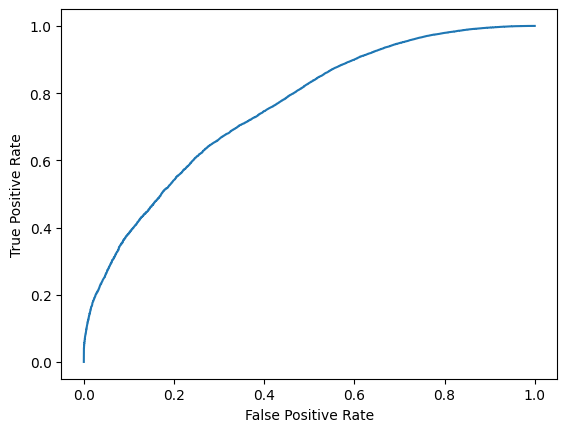

In [ ]:
import sklearn
proba = model.decision_function(pairwise_test_features)
proba

fpr, tpr, _ = sklearn.metrics.roc_curve(test_vs_actual['actual'].to_numpy(),
                                        proba)

sklearn.metrics.RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

## Shapley values

[SHAP](https://shap.readthedocs.io/en/latest/index.html) searches with / without features to give features optimal credit for the pairwise classification.

In [ ]:
import shap; shap.initjs()

NUM_SAMPLES = 40

train_sampled = shap.utils.sample(pairwise_train_features.to_numpy(), NUM_SAMPLES)
test_sampled = shap.utils.sample(pairwise_test_features.to_numpy(), NUM_SAMPLES)

explainer = shap.KernelExplainer(model.predict, train_sampled)
shap_values = explainer.shap_values(test_sampled)
# shap_values = pd.DataFrame(shap_values,
#                            columns=pairwise_test.drop(columns=['grade_diff']).columns)

shap.force_plot(explainer.expected_value,
                shap_values,
                test_sampled,
                feature_names=[name.replace('feature.', '').replace('_diff', '')
                               for name in pairwise_test.drop(columns=['grade_diff']).columns])


  0%|          | 0/40 [00:00<?, ?it/s]